# Surrogate Optimization

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import pandas as pd

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

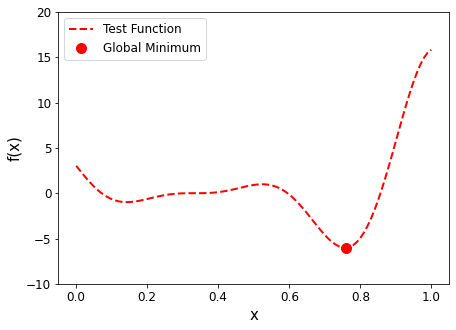

In [10]:
# Test function values
X_test = np.arange(0, 1.01, 0.01)
y_test = (X_test*6-2)**2*np.sin(X_test*12-4)

# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])

# Display global minimum
min_index = np.argmin(y_test)
ax.plot(X_test[min_index],y_test[min_index],'ro',markerfacecolor='r',markersize=10,label='Global Minimum')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12});
plt.savefig('Test_function.png')

In [3]:
# Initial training data
X_train = np.array([[0,0.1,0.2,0.4,0.6,1]]).T
y_train = (X_train*6-2)**2*np.sin(X_train*12-4)

In [4]:
# Train initial Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=1e-10, 
                                    normalize_y=True)
model.fit(X_train, y_train)

# GP prediction
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)

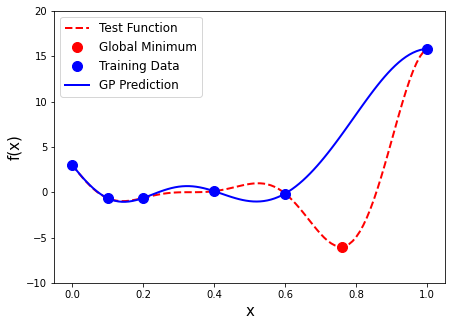

In [5]:
# Check GP prediction accuracy
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.legend(loc="upper left",prop={'size': 12});
fig